In [1]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
import  cv2
import os

from tensorflow.keras.callbacks import Callback
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd 
import tensorflow as tf
import tensorflow_addons as tfa


image_dir = "C:\\Users\\yuval\\Desktop\\subjects_100000-133332_5_imgs"
images = []
labels = []
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
            images_path = os.path.join(root, file)
            image = cv2.imread(images_path)
            image = tf.image.rgb_to_grayscale(image)
            images.append(image)
            rel_path = os.path.relpath(root, image_dir)
            label = os.path.basename(rel_path)
            labels.append(label)
images = np.array(images)
labels = np.array(labels)

def load_and_preprocess_data(image2,label2):
    x_train = image2.astype(np.float32) / 255.0
    y_train  = label2
    return x_train , y_train


C:\Users\yuval\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
def create_pairs(x,y):
    pairs = []
    labels = []
    for label in np.unique(y):
        indices = np.where(y == label)[0]
        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):
                pairs.append([x[indices[i]], x[indices[j]]])
                labels.append(1)  
                label_index = np.where(np.unique(y) == label)[0][0]
                neg_label = np.random.choice(np.delete(np.unique(y), label_index))
                neg_indices = np.where(y == neg_label)[0]
                neg_index = np.random.choice(neg_indices)
                pairs.append([x[indices[i]], x[neg_index]])
                labels.append(0)
    return np.array(pairs), np.array(labels)


In [4]:
from tensorflow.keras.layers import  BatchNormalization, Dropout
shared_cnn = Sequential([
    Conv2D(64, (7, 7) , strides = (1,1) , activation= "relu" , input_shape = x_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Conv2D(128, (3,3) , strides = (1,1) , activation = "relu"),
    BatchNormalization(), 
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(256 , (3,3) , strides = (1,1) , activation = "relu"),
    Conv2D(256 , (3,3) , strides = (1,1) , activation = "relu"),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Conv2D(512, (3,3)  , strides = (1,1) , activation = "relu") , 
    Conv2D(512 , (3,3) , strides = (1,1) , activation = "relu") ,
    BatchNormalization(),
    MaxPooling2D((2,2)) ,
    Dropout(0.3),
    Flatten(),
    Dense(2048 , activation = "sigmoid") , 
])
input_a = Input(shape=x_train.shape[1:])
input_b = Input(shape=x_train.shape[1:])
output_a = shared_cnn(input_a)
output_b = shared_cnn(input_b)
distance = Lambda(lambda x: K.abs(x[0] - x[1]))([output_a, output_b])
prediction = Dense(1, activation= "sigmoid")(distance)
siamese_model = Model(inputs=[input_a, input_b], outputs=prediction)

In [3]:

class LoggingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Epoch {epoch + 1}/{self.params["epochs"]}, Loss: {logs["loss"]}, Accuracy: {logs["accuracy"]}')

x_train, y_train = load_and_preprocess_data(images,labels)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=23)

tr_pairs, tr_y = create_pairs(x_train , y_train)

x_test , y_test  = create_pairs(x_val , y_val)

input_shape = x_train.shape[1:]



In [5]:
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime
from keras.callbacks import EarlyStopping

log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [6]:

optimizer = Adam(learning_rate = 0.001)

siamese_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

siamese_model.fit(
    x=[tr_pairs[:, 0], tr_pairs[:, 1]],
    y=tr_y,  
    validation_data=([x_test[:, 0], x_test[:, 1]], y_test),
    epochs=30,
    batch_size=32,
    callbacks=[tensorboard_callback , early_stopping]
)

Epoch 1/30
620/620 [==============================] - 1560s 3s/step - loss: 0.7090 - accuracy: 0.5731 - val_loss: 0.6841 - val_accuracy: 0.5914
Epoch 2/30
620/620 [==============================] - 1519s 2s/step - loss: 0.6481 - accuracy: 0.6241 - val_loss: 0.6467 - val_accuracy: 0.6418
Epoch 3/30
620/620 [==============================] - 1519s 2s/step - loss: 0.5951 - accuracy: 0.6769 - val_loss: 0.6563 - val_accuracy: 0.6255
Epoch 4/30
620/620 [==============================] - 1517s 2s/step - loss: 0.5563 - accuracy: 0.7123 - val_loss: 0.5648 - val_accuracy: 0.7105
Epoch 5/30
620/620 [==============================] - 1519s 2s/step - loss: 0.5332 - accuracy: 0.7306 - val_loss: 0.5504 - val_accuracy: 0.7241
Epoch 6/30
620/620 [==============================] - 1514s 2s/step - loss: 0.5005 - accuracy: 0.7593 - val_loss: 0.5017 - val_accuracy: 0.7555
Epoch 7/30
620/620 [==============================] - 1516s 2s/step - loss: 0.4734 - accuracy: 0.7775 - val_loss: 0.5211 - val_accuracy:

In [16]:
data_logs = [
    "Epoch 1/30, Loss: 0.7090, Accuracy: 0.5731, 620/620 [==============================] - 1560s 3s/step - loss: 0.7090 - accuracy: 0.5731 - val_loss: 0.6841 - val_accuracy: 0.5914",
    "Epoch 2/30, Loss: 0.6481, Accuracy: 0.6241, 620/620 [==============================] - 1519s 2s/step - loss: 0.6481 - accuracy: 0.6241 - val_loss: 0.6467 - val_accuracy: 0.6418",
    "Epoch 3/30, Loss: 0.5951, Accuracy: 0.6769, 620/620 [==============================] - 1519s 2s/step - loss: 0.5951 - accuracy: 0.6769 - val_loss: 0.6563 - val_accuracy: 0.6255",
    "Epoch 4/30, Loss: 0.5563, Accuracy: 0.7123, 620/620 [==============================] - 1517s 2s/step - loss: 0.5563 - accuracy: 0.7123 - val_loss: 0.5648 - val_accuracy: 0.7105",
    "Epoch 5/30, Loss: 0.5332, Accuracy: 0.7306, 620/620 [==============================] - 1519s 2s/step - loss: 0.5332 - accuracy: 0.7306 - val_loss: 0.5504 - val_accuracy: 0.7241",
    "Epoch 6/30, Loss: 0.5005, Accuracy: 0.7593, 620/620 [==============================] - 1514s 2s/step - loss: 0.5005 - accuracy: 0.7593 - val_loss: 0.5017 - val_accuracy: 0.7555",
    "Epoch 7/30, Loss: 0.4734, Accuracy: 0.7775, 620/620 [==============================] - 1516s 2s/step - loss: 0.4734 - accuracy: 0.7775 - val_loss: 0.5211 - val_accuracy: 0.7468",
    "Epoch 8/30, Loss: 0.4442, Accuracy: 0.7957, 620/620 [==============================] - 1517s 2s/step - loss: 0.4442 - accuracy: 0.7957 - val_loss: 0.4774 - val_accuracy: 0.7768",
    "Epoch 9/30, Loss: 0.4251, Accuracy: 0.8051, 620/620 [==============================] - 1514s 2s/step - loss: 0.4251 - accuracy: 0.8051 - val_loss: 0.4611 - val_accuracy: 0.7923",
    "Epoch 10/30, Loss: 0.4017, Accuracy: 0.8208, 620/620 [==============================] - 1515s 2s/step - loss: 0.4017 - accuracy: 0.8208 - val_loss: 0.4495 - val_accuracy: 0.7959",
    "Epoch 11/30, Loss: 0.3797, Accuracy: 0.8302, 620/620 [==============================] - 1513s 2s/step - loss: 0.3797 - accuracy: 0.8302 - val_loss: 0.4607 - val_accuracy: 0.7905",
    "Epoch 12/30, Loss: 0.3589, Accuracy: 0.8417, 620/620 [==============================] - 1515s 2s/step - loss: 0.3589 - accuracy: 0.8417 - val_loss: 0.4378 - val_accuracy: 0.8005",
    "Epoch 13/30, Loss: 0.3383, Accuracy: 0.8532, 620/620 [==============================] - 1513s 2s/step - loss: 0.3383 - accuracy: 0.8532 - val_loss: 0.4306 - val_accuracy: 0.8141",
    "Epoch 14/30, Loss: 0.3158, Accuracy: 0.8633, 620/620 [==============================] - 1511s 2s/step - loss: 0.3158 - accuracy: 0.8633 - val_loss: 0.4020 - val_accuracy: 0.8282",
    "Epoch 15/30, Loss: 0.3079, Accuracy: 0.8698, 620/620 [==============================] - 1513s 2s/step - loss: 0.3079 - accuracy: 0.8698 - val_loss: 0.5286 - val_accuracy: 0.7618",
    "Epoch 16/30, Loss: 0.2761, Accuracy: 0.8851, 620/620 [==============================] - 1512s 2s/step - loss: 0.2761 - accuracy: 0.8851 - val_loss: 0.4130 - val_accuracy: 0.8259",
    "Epoch 17/30, Loss: 0.2584, Accuracy: 0.8920, 620/620 [==============================] - 1514s 2s/step - loss: 0.2584 - accuracy: 0.8920 - val_loss: 0.4113 - val_accuracy: 0.8318",
    "Epoch 18/30, Loss: 0.2367, Accuracy: 0.9036, 620/620 [==============================] - 1512s 2s/step - loss: 0.2367 - accuracy: 0.9036 - val_loss: 0.4019 - val_accuracy: 0.8314",
    "Epoch 19/30, Loss: 0.2215, Accuracy: 0.9121, 620/620 [==============================] - 1517s 2s/step - loss: 0.2215 - accuracy: 0.9121 - val_loss: 0.3962 - val_accuracy: 0.8345",
    "Epoch 20/30, Loss: 0.2060, Accuracy: 0.9153, 620/620 [==============================] - 1515s 2s/step - loss: 0.2060 - accuracy: 0.9153 - val_loss: 0.4339 - val_accuracy: 0.8186",
    "Epoch 21/30, Loss: 0.2005, Accuracy: 0.9183, 620/620 [==============================] - 1526s 2s/step - loss: 0.2005 - accuracy: 0.9183 - val_loss: 0.4171 - val_accuracy: 0.8359",
    "Epoch 22/30, Loss: 0.1875, Accuracy: 0.9266, 620/620 [==============================] - 1622s 3s/step - loss: 0.1875 - accuracy: 0.9266 - val_loss: 0.4359 - val_accuracy: 0.8323",
    "Epoch 23/30, Loss: 0.1680, Accuracy: 0.9330, 620/620 [==============================] - 1841s 3s/step - loss: 0.1680 - accuracy: 0.9330 - val_loss: 0.4274 - val_accuracy: 0.8423",
    "Epoch 24/30, Loss: 0.1826, Accuracy: 0.9274, 620/620 [==============================] - 1515s 2s/step - loss: 0.1826 - accuracy: 0.9274 - val_loss: 0.4359 - val_accuracy: 0.8423"
]






In [17]:
import re
def log_into_db(logs):
    epochs = []
    loss_values_train = []
    accuracy_values_train = []
    loss_values_test = []
    accuracy_values_test = []

    for line in logs:
        epoch_num = re.search(r'Epoch (\d+)', line)
        loss_val_train = re.search(r'loss: (\d+\.\d+)', line)
        accuracy_val_train = re.search(r'accuracy: (\d+\.\d+)', line)
        loss_val_test =  re.search(r"val_loss: (\d+\.\d+)" , line )
        accuracy_val_test = re.search(r"val_accuracy: (\d+\.\d+)" , line )

        if epoch_num and loss_val_train and accuracy_val_train and loss_val_test and accuracy_val_test:
            epoch = int(epoch_num.group(1))
            loss_train = float(loss_val_train.group(1))
            accuracy_train = float(accuracy_val_train.group(1))
            loss_test = float(loss_val_test.group(1))
            accuracy_test  = float(accuracy_val_test.group(1))

            epochs.append(epoch)
            loss_values_train.append(loss_train)
            accuracy_values_train.append(accuracy_train)
            loss_values_test.append(loss_test)
            accuracy_values_test.append(accuracy_test)
    return pd.DataFrame({
        'Epoch': epochs,
        'Loss_Train': loss_values_train,
        'Accuracy_Train': accuracy_values_train,
        "Loss_Test" : loss_values_test , 
        "Accuracy_Test" : accuracy_values_test
    })
db_logs = log_into_db(data_logs)

In [18]:
db_logs

,Epoch,Loss_Train,Accuracy_Train,Loss_Test,Accuracy_Test
0,1,0.7090,0.5731,0.6841,0.5914
1,2,0.6481,0.6241,0.6467,0.6418
2,3,0.5951,0.6769,0.6563,0.6255
3,4,0.5563,0.7123,0.5648,0.7105
4,5,0.5332,0.7306,0.5504,0.7241
5,6,0.5005,0.7593,0.5017,0.7555
6,7,0.4734,0.7775,0.5211,0.7468
7,8,0.4442,0.7957,0.4774,0.7768
8,9,0.4251,0.8051,0.4611,0.7923
9,10,0.4017,0.8208,0.4495,0.7959


<AxesSubplot:title={'center':'Accuracy Convergence + Accuracy Comparison of Train + Test'}, xlabel='Epoch', ylabel='Accuracy Values'>

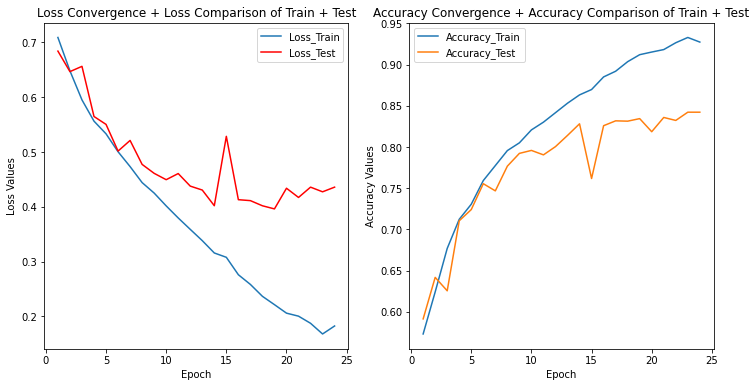

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

db_logs.plot( x = "Epoch" ,  y = "Loss_Train" , ax = axes[0] , ylabel = "Loss Values" , title = "Loss Convergence + Loss Comparison of Train + Test")
db_logs.plot( x = "Epoch" ,  y = "Loss_Test" , ax = axes[0] ,color = "red" ,ylabel = "Loss Values" , title = "Loss Convergence + Loss Comparison of Train + Test")
db_logs.plot(x = "Epoch" , y = "Accuracy_Train" , ax = axes[1] , ylabel = "Accuracy Values" , title = "Accuracy Convergence + Accuracy Comparison of Train + Test")
db_logs.plot(x = "Epoch" , y = "Accuracy_Test" , ax = axes[1] , ylabel = "Accuracy Values" , title = "Accuracy Convergence + Accuracy Comparison of Train + Test")


In [7]:
import pickle

with open('siamese_model.pkl', 'wb') as f:
    pickle.dump(siamese_model, f)
#Saving the model to prevent retraining each time the file opens

In [9]:
import pickle

with open('siamese_model.pkl', 'rb') as f:
    siamese_model = pickle.load(f)


In [20]:

def loading_images(images_test_arr, target_shape=(112, 112)):
    images_after_resize = []
    for img in images_test_arr:
        resized_img = cv2.resize(img, target_shape)
        image = tf.image.rgb_to_grayscale(resized_img)
        images_after_resize.append(image)
    return np.array(images_after_resize)

def preprocess_img_pred(image):
    normalized_img= image.astype(np.float32) / 255.0
    return normalized_img
  


In [21]:
im_input = "C://Users//yuval//Desktop//testing_SNN"
im_arr = []
for root_1,dirs_1,files_1 in os.walk(im_input):
    for file_1 in files_1:
        if file_1.endswith(".jpg") or file_1.endswith(".png") or file_1.endswith(".jpeg"):
            img_path = os.path.join(root_1,file_1)
            im_1 = cv2.imread(img_path)
            im_1 = cv2.cvtColor(im_1, cv2.COLOR_BGR2RGB)
            im_arr.append(im_1)
            path_of_im = os.path.relpath(root_1,im_input)
im_arr =loading_images(im_arr)
im_arr = preprocess_img_pred(im_arr)

In [32]:
imgs_testing_pred = [np.array([im_arr[3]]) , np.array([im_arr[4]])]

In [33]:

model_results_prediction = siamese_model.predict(imgs_testing_pred  , verbose = 0)
if model_results_prediction[0][0] > 0.5:
    print("The face which was entered is the same face with a probabillity of: \n" , model_results_prediction[0][0] )
else:
   print("The face which was entered is not the same face with probabillity of: \n" , 1 - model_results_prediction[0][0])
print(model_results_prediction)

The face which was entered is the same face with a probabillity of: 
 0.50385463
[[0.50385463]]


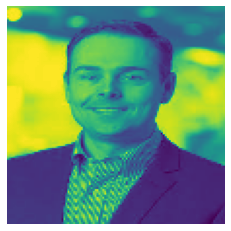

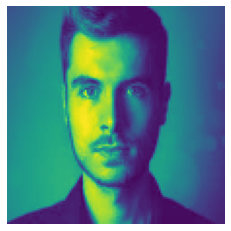

In [34]:
import matplotlib.pyplot as plt

def plot_face_from_array(image_array):
    plt.imshow(image_array)
    plt.axis('off')  
    plt.show()
plot_face_from_array(im_arr[3])
plot_face_from_array(im_arr[4])



In [1]:
x_train.shape

NameError: name 'x_train' is not defined